In [1]:
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from pymatching import Matching

In [2]:
sys.path.append("/home/sajant/Research/Berkeley/QEC/BP-Loop-Decoding/codes/")

In [3]:
import toric

In [4]:
sys.path.append("/home/sajant/Research/Berkeley/QEC/pyfssa/")
import fssa

# Phase flip noise - Toric code

## Line-by-line verification
We want to correct phase noise using MWPM. We do the following.
1. Generate the parity check matrix $H$ and logical operators $L$ for the X sector of the Toric code. We want the X stabilziers (logicals) as these anticommute with the Z noise (combined noise + recovery string)
2. Given an independent phase flip error rate $p$, sample an error string $e$. This is where the $Z$ errors are applied.
3. Compute the syndrome $s = (H @ e) \: \% \: 2$, which tells us which stabilizers are violated.
4. Use `PyMatching` to infer the most probable *individual* error $r$ given the syndrome $s$.
5. Compute the sum of error and recovery string: $(r + e) \: \% \: 2$. This new string must commute with all stabilizers.
6. Are any logicals flipped? $(L @ s) \: \% \: 2$; if we find any, a logical error $Z$ has occured.

In [5]:
d = 5

In [6]:
H = toric.toric_code_x(d)
log = toric.toric_code_logical_x(d)

In [7]:
# Physical error rate
p = 0.02
# Sample error
e = np.random.binomial(1, p, H.shape[1])
print(e)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Compute the syndrome
synd = (H @ e) % 2
print(synd)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
# Perform the matching to get the recovery string
matching = Matching(H)
r = matching.decode(synd)
print(r)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# Syndrome from combined error and recovery string, c; needs to be all zeros
c = (r + e) % 2
print((H @ c) % 2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# Compute logical action; which of 2 Z logicals did we apply?
print((log @ c) % 2)

[0 0]


## Batched approach
We now want to speed this up using the vectorized approach.

In [12]:
# taken from PyMatching documentation
def num_decoding_failures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [13]:
num_shots = 5000
Ls = range(4,26,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.toric_code_z(L)
    log = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(H, log, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
Simulating L=16...
Simulating L=20...
Simulating L=24...


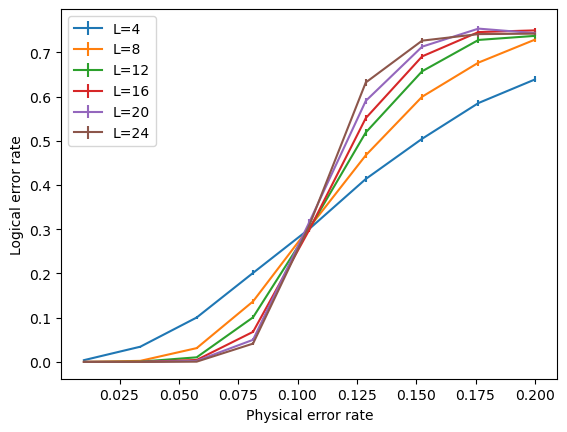

In [14]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

Nice, we see the $10.3\%$ threshold as expected. At least, we see something in this ballpark.

## Finite size scaling
Let us extract the threshold more accurately.

In [15]:
num_shots = 5000
Ls = range(4,26,4)
ps = np.linspace(0.08, 0.12, 14)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.toric_code_z(L)
    log = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(H, log, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
Simulating L=16...
Simulating L=20...
Simulating L=24...


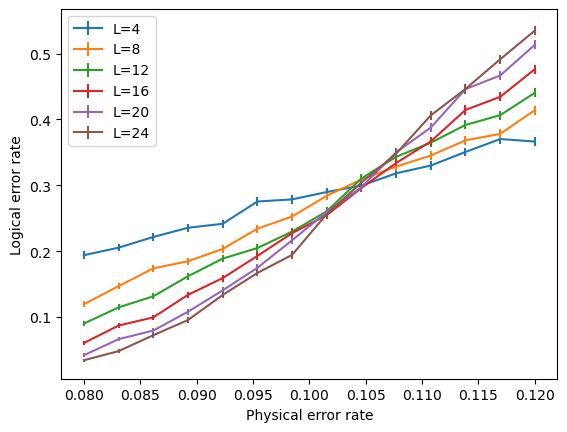

In [16]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [17]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.103, 1, 1)

/home/sajant/Research/Berkeley/QEC/pyfssa/fssa/fssa.py:165: RuntimeWarning: rho_c is out of range
  warnings.warn("rho_c is out of range", RuntimeWarning)


In [18]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.4506559704882358
             x: [ 1.065e-01  1.565e+00  5.448e-02]
           nit: 41
          nfev: 81
 final_simplex: (array([[ 1.065e-01,  1.565e+00,  5.448e-02],
                       [ 1.066e-01,  1.559e+00,  5.730e-02],
                       [ 1.065e-01,  1.570e+00,  5.206e-02],
                       [ 1.066e-01,  1.565e+00,  5.529e-02]]), array([ 1.451e+00,  1.452e+00,  1.452e+00,  1.454e+00]))
         varco: [[ 2.252e-06 -1.980e-04  8.190e-05]
                 [-1.980e-04  3.107e-02 -1.429e-02]
                 [ 8.190e-05 -1.429e-02  5.173e-03]]
        errors: [ 1.501e-03  1.763e-01  7.193e-02]
           rho: 0.1065218516988396
            nu: 1.5646231201436223
          zeta: 0.05448474050749216
          drho: 0.0015005139158564558
           dnu: 0.1762611958655384
         dzeta: 0.07192697548826872

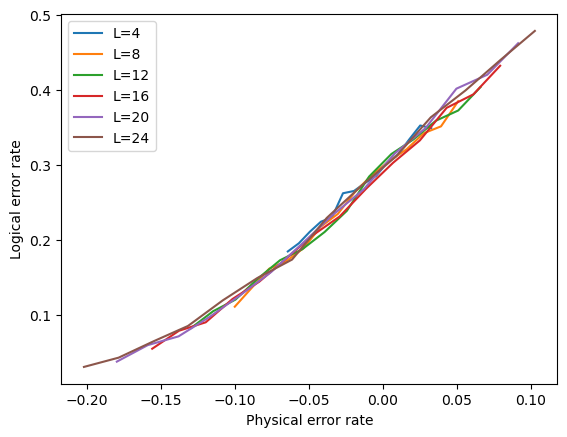

In [19]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot((ps-res['rho'])*L**(1/res['nu']), logical_errors * L**(-res['zeta']/res['nu']), label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

# Depolarizing error
For depolarizing error, we sample an random Pauli error with probability $p/3$ and an identity with $1-p$. The MWPM decoder does not account for correlations between the $X$ and $Z$ decoding problem. So we decode each separately. In principle we should ensure that for a given error string, both succeed. But since the problems are independent, we don't need to explicity do this. Really, there is no need to run depolarizing error. Depolarizing error can be treated as bit and phase flip errors with $p' = 2p /3$, so since $p'_{\mathrm{th}} \approx 10.3 \%$, $p_\mathrm{th} = 15.35 \%$.

Let us make sure this is case when we ensure that both problem succeed.

In [20]:
# taken from PyMatching documentation
def num_decoding_failures_vectorised_depolarizing(H_X, H_Z, logicals_X, logicals_Z, error_probability, num_shots):
    matching_X = Matching.from_check_matrix(H_X, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals_X)
    matching_Z = Matching.from_check_matrix(H_Z, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals_Z)
    
    # pI, pX, pZ, pY
    noise = np.random.choice(np.array([0,1,2,3], dtype=np.int8), size=(num_shots, H_X.shape[1]), p=(1-error_probability,error_probability/3,error_probability/3,error_probability/3))
    # Treat Z as identity; combine I and Z, combine X and Y
    noise_X = (noise % 2).astype(np.uint8)
    # Treat X as identity; combine I and X, combine Z and Y
    noise_Z = ((noise - 1) >= 1).astype(np.uint8)

    # Syndrome for each noise
    shots_X = (noise_X @ H_Z.T) % 2
    shots_Z = (noise_Z @ H_X.T) % 2

    # What error actually occured? Check anticommutation of error with logical
    actual_observables_X = (noise_X @ logicals_Z.T) % 2
    actual_observables_Z = (noise_Z @ logicals_X.T) % 2
    actual_observables = np.column_stack([actual_observables_X, actual_observables_Z])
    
    # Do matching
    predicted_observables_X = matching_Z.decode_batch(shots_X)
    predicted_observables_Z = matching_X.decode_batch(shots_Z)
    predicted_observables = np.column_stack([predicted_observables_X, predicted_observables_Z])
    
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [21]:
num_decoding_failures_vectorised_depolarizing(toric.toric_code_x(5), toric.toric_code_z(5), toric.toric_code_logical_x(5), toric.toric_code_logical_z(5), 0.1, 200000)

np.int64(28387)

In [22]:
num_shots = 5000
Ls = range(4,26,4)
ps = np.linspace(0.12, 0.18, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric.toric_code_x(L)
    logX = toric.toric_code_logical_x(L)
    Hz = toric.toric_code_z(L)
    logZ = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised_depolarizing(Hx, Hz, logX, logZ, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
Simulating L=16...
Simulating L=20...
Simulating L=24...


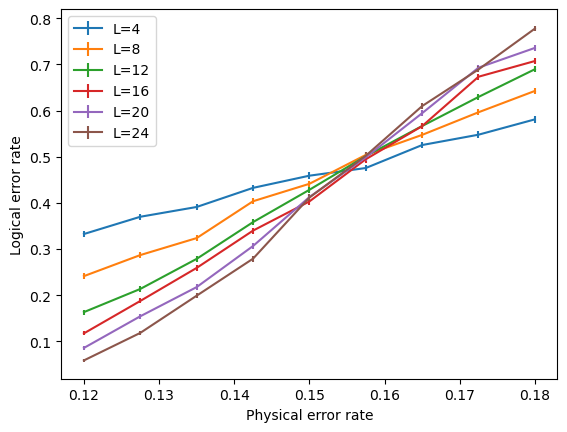

In [23]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [24]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.15, 1, 1)

In [25]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.7123964418188535
             x: [ 1.570e-01  1.572e+00  1.584e-02]
           nit: 42
          nfev: 77
 final_simplex: (array([[ 1.570e-01,  1.572e+00,  1.584e-02],
                       [ 1.566e-01,  1.576e+00,  1.043e-02],
                       [ 1.570e-01,  1.572e+00,  1.757e-02],
                       [ 1.565e-01,  1.575e+00,  9.906e-03]]), array([ 1.712e+00,  1.715e+00,  1.716e+00,  1.720e+00]))
         varco: [[ 2.293e-05 -4.637e-04  3.610e-04]
                 [-4.637e-04  3.553e-03 -1.046e-02]
                 [ 3.610e-04 -1.046e-02  7.899e-03]]
        errors: [ 4.788e-03  5.960e-02  8.888e-02]
           rho: 0.15696720953563492
            nu: 1.572157860635847
          zeta: 0.01584247685577031
          drho: 0.004788366237373391
           dnu: 0.059604092132668374
         dzeta: 0.08887647423206814

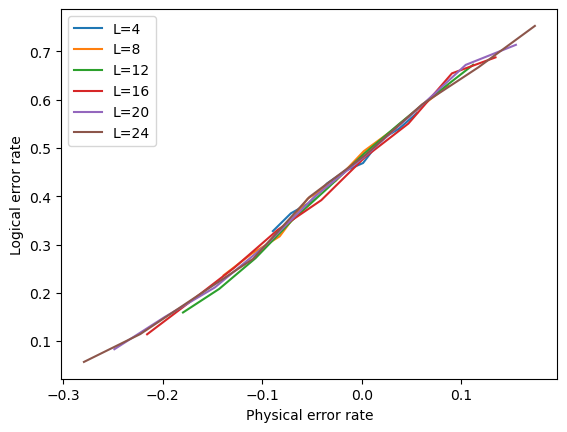

In [26]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot((ps-res['rho'])*L**(1/res['nu']), logical_errors * L**(-res['zeta']/res['nu']), label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

This works!

# Surface code

In [27]:
# taken from PyMatching documentation
def num_decoding_failures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [28]:
num_shots = 5000
Ls = range(4,22,4)
ps = np.linspace(0.08, 0.12, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.surface_code_z(L, 3)
    log = toric.surface_code_logical_z(L, 3)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(H, log, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
Simulating L=16...
Simulating L=20...


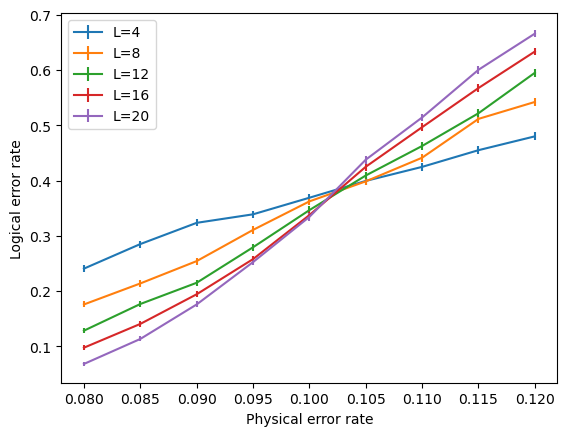

In [29]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [30]:
log_errors_all_L

[array([0.2408, 0.2852, 0.3236, 0.339 , 0.369 , 0.3994, 0.4248, 0.455 ,
        0.48  ]),
 array([0.176 , 0.214 , 0.2544, 0.3108, 0.3624, 0.3986, 0.4414, 0.5116,
        0.5422]),
 array([0.1286, 0.1768, 0.2152, 0.2794, 0.3466, 0.4092, 0.4626, 0.5218,
        0.595 ]),
 array([0.0978, 0.1408, 0.1944, 0.258 , 0.3376, 0.425 , 0.4966, 0.5674,
        0.6334]),
 array([0.0684, 0.1136, 0.176 , 0.2526, 0.3344, 0.4378, 0.5142, 0.6004,
        0.6658])]

In [33]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.1, 1, 1)
print(res['rho'])

0.09747693792271342


/home/sajant/Research/Berkeley/QEC/pyfssa/fssa/fssa.py:505: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(varco)), varco
